## Testing: PREDICTING BITCOIN PRICE USING Long Short-Term Memory MODEL

In [62]:
# Import packages

import time
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as datetime
import plotly.express as px
import nbformat



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn import preprocessing
from joblib import dump, load

np.random.seed(7)

In [63]:
# READ DATA FROM FILE
df = pd.read_csv("bitcoin_hourly.csv")
print(df.dtypes)
print("\n*** DF ***")
df_copy = df.copy()
df_copy.head(5)

unix           float64
date            object
symbol          object
open           float64
high           float64
low            float64
close          float64
Volume BTC     float64
Volume USDT    float64
tradecount     float64
dtype: object

*** DF ***


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.614384e+12,2021-02-27 00:00:00,BTC/USDT,46276.88,46628.93,46156.24,46621.39,336.166565,1.558817e+07,8582.0
1,1.614380e+12,2021-02-26 23:00:00,BTC/USDT,45476.30,46444.57,45368.74,46276.87,2571.865785,1.185428e+08,60317.0
2,1.614377e+12,2021-02-26 22:00:00,BTC/USDT,45680.00,45988.77,45000.00,45476.30,4400.975291,2.005474e+08,123927.0
3,1.614373e+12,2021-02-26 21:00:00,BTC/USDT,46270.00,46867.00,45500.00,45677.46,3831.690182,1.771737e+08,85141.0
4,1.614370e+12,2021-02-26 20:00:00,BTC/USDT,46959.18,47115.38,46071.89,46270.00,3514.297867,1.637276e+08,80837.0


In [64]:
#CLEAN DATA - SPECIFICALLY CLEAN TIMESTAMP

def change_timestamp (ts):
    digit_count = len(str(ts))
    if digit_count == 12:
        return (datetime.datetime.utcfromtimestamp(ts)).strftime('%Y-%m-%d %H:%M:%S')
    else:
        return (datetime.datetime.utcfromtimestamp(ts/1000)).strftime('%Y-%m-%d %H:%M:%S')

df_copy['unix_count'] = df.unix.apply(lambda x: len(str(x)))        
df_copy['dt_correct'] = df.unix.apply(lambda x: change_timestamp(x))
df_copy['dt'] = pd.to_datetime(df_copy.dt_correct.values)
df_copy['hour'] = df_copy.dt.apply(lambda x: x.hour)
df_copy['week_day'] = df_copy.dt.apply(lambda x: x.weekday())
df_copy.sort_values(by=['unix'],ascending=[True],inplace=True)

print(df_copy.dtypes)
print(df_copy.unix_count.unique())
df_copy.tail(5)

unix                  float64
date                   object
symbol                 object
open                  float64
high                  float64
low                   float64
close                 float64
Volume BTC            float64
Volume USDT           float64
tradecount            float64
unix_count              int64
dt_correct             object
dt             datetime64[ns]
hour                    int64
week_day                int64
dtype: object
[12 15]


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount,unix_count,dt_correct,dt,hour,week_day
4,1.614370e+12,2021-02-26 20:00:00,BTC/USDT,46959.18,47115.38,46071.89,46270.00,3514.297867,1.637276e+08,80837.0,15,2021-02-26 20:00:00,2021-02-26 20:00:00,20,4
3,1.614373e+12,2021-02-26 21:00:00,BTC/USDT,46270.00,46867.00,45500.00,45677.46,3831.690182,1.771737e+08,85141.0,15,2021-02-26 21:00:00,2021-02-26 21:00:00,21,4
2,1.614377e+12,2021-02-26 22:00:00,BTC/USDT,45680.00,45988.77,45000.00,45476.30,4400.975291,2.005474e+08,123927.0,15,2021-02-26 22:00:00,2021-02-26 22:00:00,22,4
1,1.614380e+12,2021-02-26 23:00:00,BTC/USDT,45476.30,46444.57,45368.74,46276.87,2571.865785,1.185428e+08,60317.0,15,2021-02-26 23:00:00,2021-02-26 23:00:00,23,4
0,1.614384e+12,2021-02-27 00:00:00,BTC/USDT,46276.88,46628.93,46156.24,46621.39,336.166565,1.558817e+07,8582.0,15,2021-02-27 00:00:00,2021-02-27 00:00:00,0,5


In [65]:
df_work = df_copy[['dt','hour','week_day','close','Volume BTC']]

In [66]:
#SPLIT DATA INTO TEST AND TRAIN
np.random.seed(7)

X = df_work[['hour','week_day','Volume BTC','close']]
Y = df_work[['close']]


#NORMALIZATION
f_transformer = preprocessing.MinMaxScaler((-1,1))
f_transformer = f_transformer.fit(X)

cnt_transformer = preprocessing.MinMaxScaler((-1,1))
cnt_transformer = cnt_transformer.fit(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)

X_train_trans = f_transformer.transform(X_train)
X_test_trans = f_transformer.transform(X_test)

y_train_trans = cnt_transformer.transform(y_train)
y_test_trans = cnt_transformer.transform(y_test)

print("*** SHAPES")
print("X_train: %s, %s" % (X_train.shape[0],X_train.shape[1]))
print("X_test: %s, %s" % (X_test.shape[0],X_test.shape[1]))
print("y_train: %s, %s" % (y_train.shape[0],y_train.shape[1]))
print("y_test: %s, %s" % (y_test.shape[0],y_test.shape[1]))

print("\n*** MIN MAX")

print("TRAIN COST: %d, %d" % (X_train.close.min(), X_train.close.max()))
print("TEST COST: %d, %d" % (X_test.close.min(), X_test.close.max()))
print("TRAIN VOL: %d, %d" % (X_train['Volume BTC'].min(), X_train['Volume BTC'].max()))
print("TEST VOL: %d, %d" % (X_test['Volume BTC'].min(), X_test['Volume BTC'].max()))

print("\n*** MIN MAX PARAMETER")
print(f_transformer.data_min_)
print(f_transformer.data_max_)
print(cnt_transformer.data_min_)
print(cnt_transformer.data_max_)

*** SHAPES
X_train: 26876, 4
X_test: 6720, 4
y_train: 26876, 1
y_test: 6720, 1

*** MIN MAX
TRAIN COST: 2919, 19709
TEST COST: 9946, 58183
TRAIN VOL: 0, 47255
TEST VOL: 0, 32057

*** MIN MAX PARAMETER
[   0.    0.    0. 2919.]
[2.300000e+01 6.000000e+00 4.725576e+04 5.818369e+04]
[2919.]
[58183.69]


In [67]:
#CREATE LAGGING DATASET FOR TIMESERIES
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
# reshape to [samples, time_steps, n_features]
X_train_f, y_train_f = create_dataset(X_train_trans, y_train_trans, time_steps)
X_test_f, y_test_f = create_dataset(X_test_trans, y_test_trans, time_steps)

print("*** SHAPES")
print(X_train_f.shape, y_train_f.shape)
print(X_test_f.shape, y_test_f.shape)

*** SHAPES
(26852, 24, 4) (26852, 1)
(6696, 24, 4) (6696, 1)


In [68]:
# Building the model
model = keras.Sequential()
model.add(keras.Input(shape=((X_train_f.shape[1], X_train_f.shape[2]))))

model.add(layers.LSTM(300, return_sequences=False, activation = 'tanh'))
model.add(layers.BatchNormalization())

model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 300)               366000    
                                                                 
 batch_normalization_5 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 301       
                                                                 
Total params: 367,501
Trainable params: 366,901
Non-trainable params: 600
_________________________________________________________________


In [69]:
#Higher number of epochs is better, recommend around 50 but my laptop cant handle it 
hist = model.fit(X_train_f, y_train_f, batch_size = 200, epochs = 3, shuffle=False, validation_split=0.1)

Epoch 1/3
121/121 [==============================] - 21s 155ms/step - loss: 0.2799 - val_loss: 0.0113
Epoch 2/3
121/121 [==============================] - 17s 141ms/step - loss: 0.0128 - val_loss: 0.0122
Epoch 3/3
121/121 [==============================] - 16s 134ms/step - loss: 0.0133 - val_loss: 0.0085


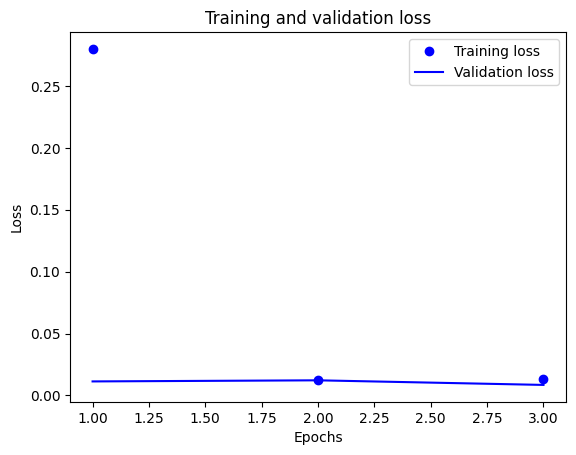

In [70]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
y_pred = model.predict(X_test_f) 

y_test_inv = cnt_transformer.inverse_transform(y_test_f)
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
combined_array = np.concatenate((y_test_inv,y_pred_inv),axis=1)
combined_array2 = np.concatenate((X_test.iloc[time_steps:],combined_array),axis=1)

df_final = pd.DataFrame(data = combined_array, columns=["actual", "predicted"])
print("size: %d" % (len(combined_array)))
df_final.head(4)

210/210 [==============================] - 5s 21ms/step
size: 6696


,actual,predicted
0,10223.57,8799.286133
1,10284.47,8742.816406
2,10259.81,8630.545898
3,10260.75,8493.347656


In [72]:
results = model.evaluate(X_test_f, y_test_f)

print("mse: %s" % (mean_squared_error(y_test_inv, y_pred_inv)))
print(results)

210/210 [==============================] - 4s 20ms/step - loss: 0.1921
mse: 146643430.37147915
0.19205567240715027


In [73]:
##PREPARING DATA FOR PLOTLY

a = np.repeat(1, len(y_test_inv))
b = np.repeat(2, len(y_pred_inv))

df1 = pd.DataFrame(data = np.concatenate((y_test_inv,(np.reshape(a, (-1, 1)))),axis=1), columns=["price","type"])
df2 = pd.DataFrame(data = np.concatenate((y_pred_inv,(np.reshape(b, (-1, 1)))),axis=1), columns=["price","type"])

frames = [df1, df2]
result = pd.concat(frames, ignore_index=False)

result["type"].replace({1: "actual", 2: "predict"}, inplace=True)
(result[result.type == "actual"]).head(10)

,price,type
0,10223.57,actual
1,10284.47,actual
2,10259.81,actual
3,10260.75,actual
4,10293.61,actual
5,10319.05,actual
6,10285.47,actual
7,10252.60,actual
8,10289.42,actual
9,10262.41,actual


In [74]:
(result[result.type == "predict"]).head(10)

,price,type
0,8799.286133,predict
1,8742.816406,predict
2,8630.545898,predict
3,8493.347656,predict
4,8346.723633,predict
5,8211.554688,predict
6,8069.397461,predict
7,7933.515137,predict
8,7806.728027,predict
9,7694.393066,predict


In [76]:
fig = px.line(result, x=result.index.values, y="price", color='type', title='Bitcoin Price')
fig.show()